In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import warnings
from datetime import datetime

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#Загрузка данных
def init_data(col_for_prediction, sample_ind = 'sample', data_ind = "data_ind"):
    '''Загрузка фалов csv (test и train). Формирование единой таблицы'''
    df_train = pd.read_csv('main_task.zip')
    df_pred = pd.read_csv('kaggle_task.zip')

    df_train[sample_ind] = 1# train+test
    df_pred[sample_ind] = 0 # предсказание
    df_pred[col_for_prediction] = 0 # выход
    data = df_train.append(df_pred, sort=False).reset_index(drop=True) # объединяем
    data = data.reset_index()
    data = data.rename(columns={"index": data_ind})   
    return data

data = init_data(col_for_prediction = 'Rating', sample_ind = 'sample', data_ind = "data_ind")

In [3]:
def data_stats_table(data, data_example = True, nlargest_num = 1, stats_describe = True):
    '''Функция описания табличных данных (Nans, дубли, частоты значений, описательная статистика)
       Переменные:
       data (DataFrame) - таблица для описания данных
       data_example (bolean) - вывод примера данных в описании
       nlargest_num (int) - количество основных частот в описании
       stats_describe (bolean) - вывод описательной статистики   
    '''
    data_stats = pd.DataFrame()

    if data_example:  # пример данных
        data_stats['data[0]'] = data.loc[0, :].T

    data_stats['dtypes'] = data.dtypes  # типы переменных
    data_stats.loc['rows_count', 'dtypes'] = len(data.dtypes)

    # расчет количества дублей
    data_stats['dupl'] = int(data.duplicated().sum())

    data_stats['NaNs'] = data.isnull().sum()  # Расчет количества NaNs
    data_stats.loc['rows_count', 'NaNs'] = (
        data.isnull().sum(axis=1) != 0).sum()
    data_stats['NaNs'] = data_stats['NaNs'].astype('int')

    # Расчет частот уникальных значений (частоты нормированы)
    for name in data.columns:
        data_stats.loc[name, 'unique'] = data[name].nunique()
        top_freq = round(data[name].value_counts(
            normalize=True).nlargest(nlargest_num), 2)
        data_stats.loc[name, 'top_freq'] = json.dumps(list(top_freq))
        data_stats.loc[name, 'top_freq_value'] = json.dumps(
            list(top_freq.index))

    if stats_describe:  # описательная статистика
        df_des = round(data.describe().T.drop(columns=['count']), 2)
        data_stats = pd.concat([data_stats, df_des], axis=1, sort=False)

    data_stats.fillna("", inplace=True)

    return data_stats


data_stats_table(data, nlargest_num=3, data_example = False, stats_describe = True)

,dtypes,dupl,NaNs,unique,top_freq,top_freq_value,mean,std,min,25%,50%,75%,max
data_ind,int64,0,0,50000,"[0.0, 0.0, 0.0]","[2047, 36155, 40281]",24999.5,14433.9,0,12499.8,24999.5,37499.2,49999
Restaurant_id,object,0,0,13094,"[0.0, 0.0, 0.0]","[""id_871"", ""id_436"", ""id_633""]",,,,,,,
City,object,0,0,31,"[0.14, 0.12, 0.08]","[""London"", ""Paris"", ""Madrid""]",,,,,,,
Cuisine Style,object,0,11590,10731,"[0.03, 0.03, 0.02]","[""['Italian']"", ""['French']"", ""['Spanish']""]",,,,,,,
Ranking,float64,0,0,12975,"[0.0, 0.0, 0.0]","[93.0, 491.0, 72.0]",3664.43,3700.09,1,972,2278,5241,16444
Rating,float64,0,0,10,"[0.27, 0.22, 0.2]","[4.0, 4.5, 0.0]",3.19,1.71,0,3,4,4.5,5
Price Range,object,0,17361,3,"[0.71, 0.24, 0.05]","[""$$ - $$$"", ""$"", ""$$$$""]",,,,,,,
Number of Reviews,float64,0,3200,1573,"[0.05, 0.04, 0.04]","[2.0, 3.0, 4.0]",124.47,294.11,2,9,33,115,9660
Reviews,object,0,2,41857,"[0.16, 0.0, 0.0]","[""[[], []]"", ""[['Excellent food food', 'Fantas...",,,,,,,
URL_TA,object,0,0,49963,"[0.0, 0.0, 0.0]","[""/Restaurant_Review-g187514-d7809594-Reviews-...",,,,,,,


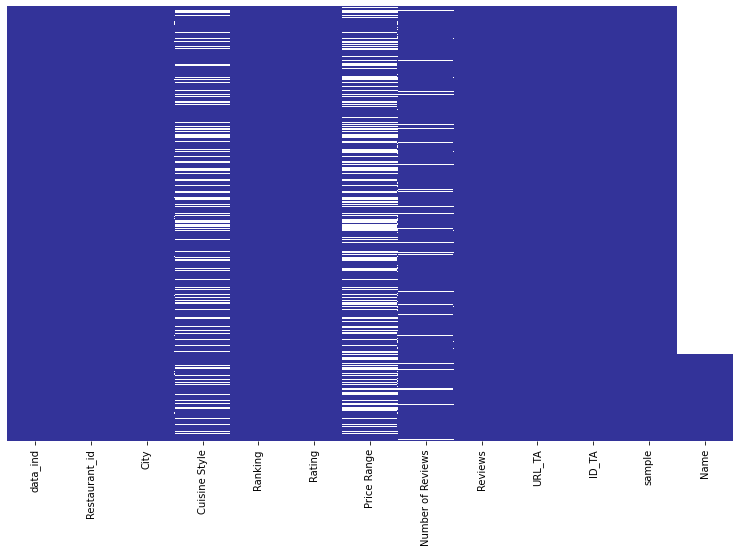

In [4]:
# Предсавление NaNs в DataFrame
fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='terrain'); #terrain tab20c Purples Greys

### Выводы по описанию данных
1. Основные типы признаков: number и object
2. Дубликатов строк нет
3. Признаки с большим количеством Nans: **Cuisine Style, Price Range**. Применение dropna приведет к большим потерям в данных, поэтому требуется более акуртаное их заполнение. Если признаки окажуться не значимыми можно будет их удалить
4. Текстовый признак текстовый **Reviews** имеет малое количество Nans,  заменим их на пустую строку ""
4. Признака **Name** нет в обучающих данных, поэтому он для модели бесполезен, хотя может быть использован при интерпретации если будет обнаружена связь с другими признаками
5. Типы признаков:
    * Бинарных признаков нет.
    * Категориальные (не бинарные) признаки:
       - **Price Range, City** - для заполнения Nans, используем частоту
       - **Restaurant_id, ID_TA** - ID использоваться не будут
    * Multi-Label признак
       - **Cuisine Style** - требуется распаковка признака. Nans можно заменить на признак отсутвия стиля и при распаковки его не учитывать.
    * Текстовые признаки
       - **Reviews** - требуется привлечение методов NLP для обработки
       - **URL_TA** - ссылки для парсинга доп. даных
    * Числовые признаки:
        - **Number of Reviews** - есть тяжелый хвост, признак логарифмируем и для заполнения Nans, используем медиану
        - **Ranking, Rating** - требуется исследовать отдельно, Ranking возможно имеет тяжелый хвост в распределении

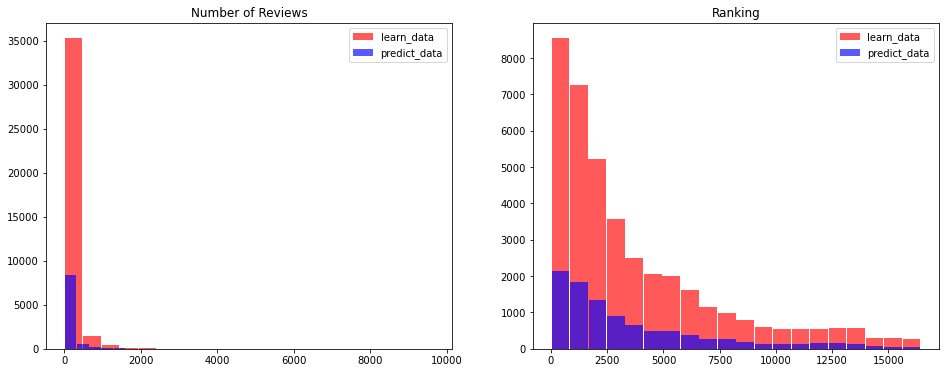

In [5]:
def plot_train_test_hist(data_, col_names, col_number=2, figsize_=(18, 8), bins_=10):
    '''Функция для визуализации гистограмм на данных для обучения и предсказания'''
    fig, axes_ = plt.subplots(-(-len(col_names)//col_number),
                              col_number, figsize=figsize_)

    for counter_ in range(len(col_names)):
        pic_row_ = counter_//col_number
        pic_col_ = counter_ % col_number
        if len(col_names) <= col_number:            
            if len(col_names) == 1:
                ax = axes_
            else:
                ax = axes_[pic_col_]
        else:
            ax = axes_[pic_row_, pic_col_]        
        ax.hist(data_[data_['sample'] == 1][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='learn_data', color='red', bins=bins_)

        ax.hist(data_[data_['sample'] == 0][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='predict_data', color='blue', bins=bins_)
        ax.set_title(col_names[counter_])
        ax.legend(loc=1)


num_cols = ['Number of Reviews', 'Ranking']
plot_train_test_hist(data, num_cols, col_number=2, figsize_=(16, 6), bins_=20)

### Выводы
1. Признаки **Number of Reviews, Ranking** педлагается прологарифмировать, что бы сделать признаки более "нормальными"

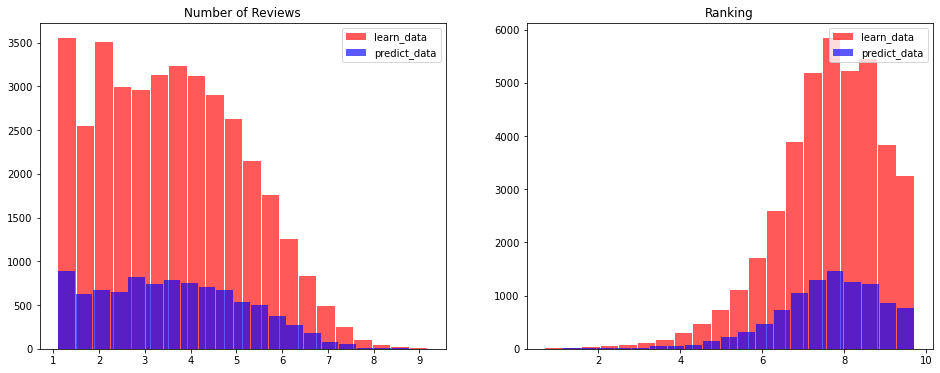

In [6]:
log_cols = ['Number of Reviews', 'Ranking']
for i in log_cols:
    data[i] = np.log(1+data[i].values)

plot_train_test_hist(data, num_cols, col_number=2, figsize_=(16, 6), bins_=20)

### Выводы
1. Распределения признаков **Number of Reviews, Ranking** в данных для обучения и предсказания схожи, перекосов нет

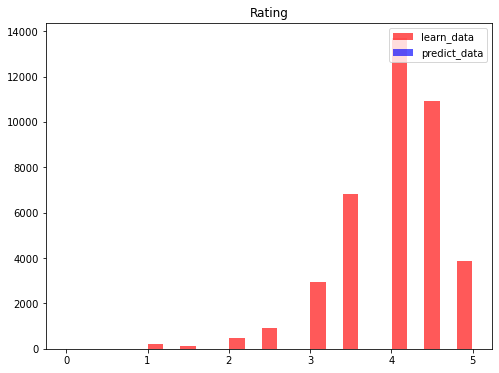

In [7]:
num_cols = ['Rating']
plot_train_test_hist(data[data['sample'] == 1], num_cols, col_number=1, figsize_=(8, 6), bins_=20)

### Выводы
1. Целевой признаков **Rating** имеет нормальное распределение, с максимальной частотой при значениии 4

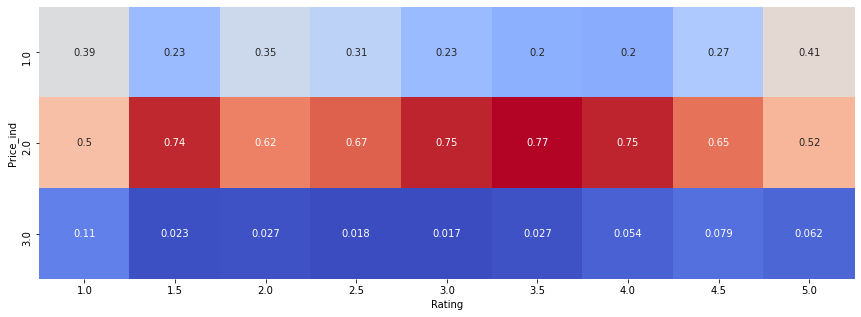

In [8]:
def plot_cross_tab(data_, col_names, target_name, figsize_=(18, 8), transpose = False):
    '''Функция визуализации кросстабуляции категориальных признаков'''
    for col_name in col_names:
        df = data[data['sample'] == 1]
        df_cross_tab = pd.crosstab(df[target_name], df[col_name], normalize='index')
        df_cross_tab = np.round(df_cross_tab, 3)
        plt.figure(figsize=figsize_)
        if transpose:
            df_cross_tab  = df_cross_tab.T
        sns.heatmap(df_cross_tab, annot=True, square=True,
                    cmap='coolwarm', cbar=False)
        plt.show

Price_dict = {'$' : 1.0, '$$ - $$$' : 2.0,  '$$$$' : 3.0}
data['Price_ind'] = data['Price Range'].apply(lambda x: x if pd.isnull(x) else Price_dict[x])
        
cat_cols = ['Price_ind']
plot_cross_tab(data[~data['Price Range'].isnull()], cat_cols, target_name='Rating', figsize_=(16, 5), transpose = True)

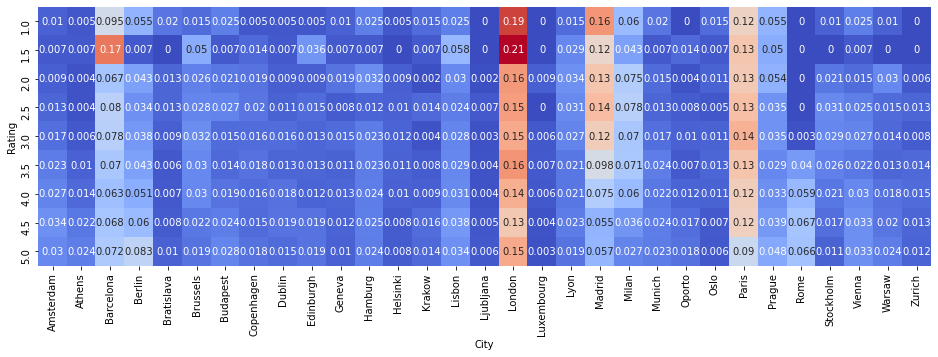

In [9]:
cat_cols = ['City']
plot_cross_tab(data, cat_cols, target_name='Rating', figsize_=(16, 10))

### Выводы
1. Явных разделяющих признаков среди категориальных не наблюдается, однако некоторые dummy переменные от признака City могут оказаться перспективны
2. Дальнейшее исследование категориальных признаков будет проведено с помощью нелинейных моделей (деревьев решений)

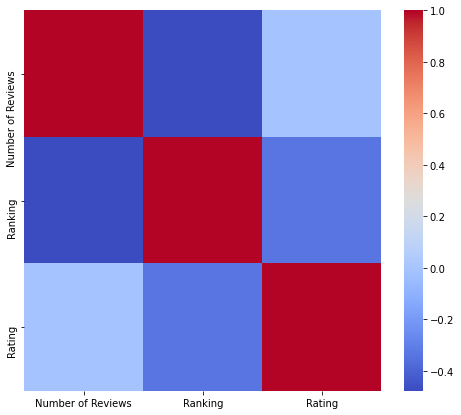

In [10]:
num_cols = ['Number of Reviews', 'Ranking', 'Rating']
plt.rcParams['figure.figsize'] = (8, 7)
sns.heatmap(data[data['sample'] == 1][num_cols].corr(), cmap='coolwarm');

### Выводы
1. Явных коррелирующих числовых признаков с целевым признаков не наблюдается
2. Дальнейшее исследование числовых признаков будет проведено с помощью нелинейных моделей (деревьев решений)